## Deep face recognition 

Face recognition identifies persons on face images or video frames. In a nutshell, a face recognition system extracts features from an input face image and compares them to the features of labeled faces in a database. Comparison is based on a feature similarity metric and the label of the most similar database entry is used to label the input image. If the similarity value is below a certain threshold the input image is labeled as *unknown*. Comparing two face images to determine if they show the same person is known as face verification.

This notebook uses a deep convolutional neural network (CNN) to extract features from input images. It follows the approach described in [[1]](https://arxiv.org/abs/1503.03832) with modifications inspired by the [OpenFace](http://cmusatyalab.github.io/openface/) project. [Keras](https://keras.io/) is used for implementing the CNN, [Dlib](http://dlib.net/) and [OpenCV](https://opencv.org/) for aligning faces on input images. Face recognition performance is evaluated on a small subset of the [LFW](http://vis-www.cs.umass.edu/lfw/) dataset which you can replace with your own custom dataset e.g. with images of your family and friends if you want to further experiment with this notebook. After an overview of the CNN architecure and how the model can be trained, it is demonstrated how to:

- Detect, transform, and crop faces on input images. This ensures that faces are aligned before feeding them into the CNN. This preprocessing step is very important for the performance of the neural network.
- Use the CNN to extract 128-dimensional representations, or *embeddings*, of faces from the aligned input images. In embedding space, Euclidean distance directly corresponds to a measure of face similarity. 
- Compare input embedding vectors to labeled embedding vectors in a database. Here, a support vector machine (SVM) and a KNN classifier, trained on labeled embedding vectors, play the role of a database. Face recognition in this context means using these classifiers to predict the labels i.e. identities of new inputs.

### Environment setup

For running this notebook, create and activate a new [virtual environment](https://docs.python.org/3/tutorial/venv.html) and install the packages listed in [requirements.txt](requirements.txt) with `pip install -r requirements.txt`. Furthermore, you'll need a local copy of Dlib's face landmarks data file for running face alignment:

In [1]:
!git clone https://github.com/05rs/Face-Recogination.git
import sys
sys.path.append('./Face-Recogination/FaceNet')
# !pip install -r '/content/Face-Recogination/FaceNet/requirements.txt'
import align
import data
import utils
import model
import matplotlib.pyplot as plt


Cloning into 'Face-Recogination'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 479 (delta 23), reused 46 (delta 6), pack-reused 407
Receiving objects: 100% (479/479), 152.04 MiB | 6.70 MiB/s, done.
Resolving deltas: 100% (30/30), done.
Checking out files: 100% (626/626), done.


In [3]:
import pickle

pkl_file = open('/content/Face-Recogination/FaceNet/data/data.pkl', 'rb')
data = pickle.load(pkl_file)
# pckl files...
seq = data['seq']             # Label key
itr = data['itr']             # iterator
embedded = data['embedded']   # 100 dims embedded vec
label = data['label']         # encoded label
images = data['images']       # raw image
decode_label = { seq[k]:k for k in seq.keys()}


In [4]:
def _pairwise_distances(embeddings, squared=True):
    """Compute the 2D matrix of distances between all the embeddings.
    Args:
        embeddings: tensor of shape (batch_size, embed_dim)
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        pairwise_distances: tensor of shape (batch_size, batch_size)
    """
    # Get the dot product between all embeddings
    # shape (batch_size, batch_size)
    dot_product = tf.matmul(embeddings, tf.transpose(embeddings))

    # Get squared L2 norm for each embedding. We can just take the diagonal of `dot_product`.
    # This also provides more numerical stability (the diagonal of the result will be exactly 0).
    # shape (batch_size,)
    square_norm = tf.linalg.diag_part(dot_product)

    # Compute the pairwise distance matrix as we have:
    # ||a - b||^2 = ||a||^2  - 2 <a, b> + ||b||^2
    # shape (batch_size, batch_size)
    distances = tf.expand_dims(square_norm, 1) - 2.0 * dot_product + tf.expand_dims(square_norm, 0)

    # Because of computation errors, some distances might be negative so we put everything >= 0.0
    distances = tf.maximum(distances, 0.0)

    if not squared:
        # Because the gradient of sqrt is infinite when distances == 0.0 (ex: on the diagonal)
        # we need to add a small epsilon where distances == 0.0
        mask = tf.dtypes.cast(tf.equal(distances, 0.0), tf.dtypes.float64)
        distances = tf.dtypes.cast(distances,tf.dtypes.float64) + mask * tf.dtypes.cast(1e-16,tf.dtypes.float64)


        distances = tf.sqrt(distances)

        # Correct the epsilon added: set the distances on the mask to be exactly 0.0
        distances = distances * (1.0 - mask)

    return distances

### CNN architecture and training

The CNN architecture used here is a variant of the inception architecture [[2]](https://arxiv.org/abs/1409.4842). More precisely, it is a variant of the NN4 architecture described in [[1]](https://arxiv.org/abs/1503.03832) and identified as [nn4.small2](https://cmusatyalab.github.io/openface/models-and-accuracies/#model-definitions) model in the OpenFace project. This notebook uses a Keras implementation of that model whose definition was taken from the [Keras-OpenFace](https://github.com/iwantooxxoox/Keras-OpenFace) project. The architecture details aren't too important here, it's only useful to know that there is a fully connected layer with 128 hidden units followed by an L2 normalization layer on top of the convolutional base. These two top layers are referred to as the *embedding layer* from which the 128-dimensional embedding vectors can be obtained. The complete model is defined in [model.py](model.py) and a graphical overview is given in [model.png](model.png). A Keras version of the nn4.small2 model can be created with `create_model()`.

In [5]:
import tensorflow_addons as tfa
nn4_small2= create_model()
nn4_small2.load_weights('/content/Face-Recogination/FaceNet/weights/nn4.small2.v1.h5')

Model training aims to learn an embedding $f(x)$ of image $x$ such that the squared L2 distance between all faces of the same identity is small and the distance between a pair of faces from different identities is large. This can be achieved with a *triplet loss* $L$ that is minimized when the distance between an anchor image $x^a_i$ and a positive image $x^p_i$ (same identity) in embedding space is smaller than the distance between that anchor image and a negative image $x^n_i$ (different identity) by at least a margin $\alpha$.

$$L = \sum^{m}_{i=1} \large[ \small {\mid \mid f(x_{i}^{a}) - f(x_{i}^{p})) \mid \mid_2^2} - {\mid \mid f(x_{i}^{a}) - f(x_{i}^{n})) \mid \mid_2^2} + \alpha \large ] \small_+$$

$[z]_+$ means $max(z,0)$ and $m$ is the number of triplets in the training set. The triplet loss in Keras is best implemented with a custom layer as the loss function doesn't follow the usual `loss(input, target)` pattern. This layer calls `self.add_loss` to install the triplet loss:

In [6]:
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Layer

# Input for anchor, positive and negative images
in_a = Input(shape=(96, 96, 3))
in_p = Input(shape=(96, 96, 3))
in_n = Input(shape=(96, 96, 3))

# Output for anchor, positive and negative embedding vectors
# The nn4_small model instance is shared (Siamese network)
emb_a = nn4_small2(in_a)
emb_p = nn4_small2(in_p)
emb_n = nn4_small2(in_n)

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
triplet_loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([emb_a, emb_p, emb_n])

# Model that can be trained with anchor, positive negative images
nn4_small2_train = Model([in_a, in_p, in_n], triplet_loss_layer)

In [7]:
import tensorflow as tf
import numpy as np

(Anchor) label: Gerhard_Schroeder
(Positive) label: Gerhard_Schroeder, Dist: 0.53
(Negative) label: Jacques_Chirac, Dist: 0.57


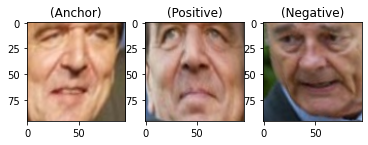

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices((np.array(itr), np.array(label)))
BATCH_SIZE = 20
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

for x,y in train_dataset:

    mask = x.numpy().reshape(BATCH_SIZE).astype('int')
    emb = embedded[mask]
    pic = images[mask]
    lbls = label[mask]
    enc_dis = _pairwise_distances(emb)
    anchor = np.zeros((BATCH_SIZE, 96,96,3))
    positive = np.zeros((BATCH_SIZE, 96,96,3))
    negative = np.zeros((BATCH_SIZE, 96,96,3))
    # print(y)
    for idx in range(len(x)):
      lbl = lbls[idx]
      pos_mask = np.where((lbls==lbl))
      slce_enc_dist = (enc_dis[:,idx].numpy().reshape(BATCH_SIZE,1))
      # print(slce_enc_dist)
      pos_masked_emb = slce_enc_dist[pos_mask]
      # print('labels : ',lbls)
      # print('pos masked encode dist : ',pos_masked_emb)
      if len(pos_masked_emb)<2:
        continue
      else:
        pos_emb = tf.math.reduce_max(pos_masked_emb, axis=0)
        pos_idx = np.where(slce_enc_dist == pos_emb)[0]
        # print('positive: ', pos_emb,pos_idx)
        neg_mask = np.where((lbls!=lbl))
        neg_masked_emb = slce_enc_dist[neg_mask]
        # print('negmasked encode dist : ',neg_masked_emb)
        neg_emb = tf.math.reduce_min(neg_masked_emb, axis=0)
        neg_idx = np.where(slce_enc_dist == neg_emb)[0]
        # print('negative: ', neg_emb,neg_idx)
        # print(min(neg_masked_emb))
           
        plt.subplot(131)
        plt.imshow(pic[idx])
        plt.title('(Anchor)')

        # Show positive 
        plt.subplot(132)
        plt.imshow(pic[pos_idx][0])
        plt.title('(Positive)')
        # Show negative
        plt.subplot(133)
        plt.imshow(pic[neg_idx][0])
        plt.title('(Negative)')

        print('(Anchor) label: {}'.format(decode_label[lbls[idx][0]] ) )
        print('(Positive) label: {}, Dist: {}'.format(decode_label[lbls[pos_idx][0][0]], "%.2f" % pos_emb))
        print('(Negative) label: {}, Dist: {}'.format(decode_label[lbls[neg_idx][0][0]], "%.2f" %neg_emb))
      break
    break

## Triplet DataGenerator
Generates semi-hard triplets in batches from dataset.

In [10]:
# triplet_generator() creates a generator that continuously returns 
# ([a_batch, p_batch, n_batch], None) tuples where a_batch, p_batch 
# and n_batch are batches of anchor, positive and negative RGB images 
# each having a shape of (batch_size, 96, 96, 3).
def triplet_generator():
    ''' Semi-hard online triplet generator.
    :return: a batch of (anchor, positive, negative) triplets
    '''
    # embedded = np.array(nn4_small2.predict(images))
    while True:  
      
        train_dataset = tf.data.Dataset.from_tensor_slices((np.array(itr), np.array(label)))
        BATCH_SIZE = 100
        SHUFFLE_BUFFER_SIZE = 100

        train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE)
        train_dataset = train_dataset.batch(BATCH_SIZE)

        for x,y in train_dataset:

            mask = x.numpy().reshape(BATCH_SIZE).astype('int')
            emb = embedded[mask]
            pic = images[mask]
            lbls = label[mask]
            enc_dis = _pairwise_distances(emb)
            anchor = []
            positive = []
            negative = []
            # print(y)
            for idx in range(len(x)):
              lbl = lbls[idx]
              pos_mask = np.where((lbls==lbl))
              slce_enc_dist = (enc_dis[:,idx].numpy().reshape(BATCH_SIZE,1))
              # print(slce_enc_dist)
              pos_masked_emb = slce_enc_dist[pos_mask]
              # print('labels : ',lbls)
              # print('pos masked encode dist : ',pos_masked_emb)
              if len(pos_masked_emb)<2:
                continue
              else:
                pos_emb = tf.math.reduce_max(pos_masked_emb, axis=0)
                pos_idx = np.where(slce_enc_dist == pos_emb)[0]
                # print('positive: ', pos_emb,pos_idx)
                neg_mask = np.where((lbls!=lbl))
                neg_masked_emb = slce_enc_dist[neg_mask]
                # print('negmasked encode dist : ',neg_masked_emb)
                neg_emb = tf.math.reduce_min(neg_masked_emb, axis=0)
                neg_idx = np.where(slce_enc_dist == neg_emb)[0]
                # print('negative: ', neg_emb,neg_idx)
                # print(min(neg_masked_emb))
                anchor.append(pic[idx])
                positive.append(pic[pos_idx][0])
                negative.append(pic[neg_idx][0])
            yield [np.array(anchor) , np.array(positive), np.array(negative)], None
    
            # embedded = np.array(nn4_small2_train.predict(images))

generator = triplet_generator()
nn4_small2_train.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=tfa.losses.TripletSemiHardLoss())

history = nn4_small2_train.fit(generator, epochs=8, steps_per_epoch=50)

Epoch 1/8
50/50 [==============================] - 52s 1s/step - loss: 0.1411
Epoch 2/8
50/50 [==============================] - 52s 1s/step - loss: 0.0000e+00
Epoch 3/8
50/50 [==============================] - 53s 1s/step - loss: 0.0000e+00
Epoch 4/8
50/50 [==============================] - 53s 1s/step - loss: 0.0000e+00
Epoch 5/8
50/50 [==============================] - 52s 1s/step - loss: 0.0000e+00
Epoch 6/8
50/50 [==============================] - 52s 1s/step - loss: 0.0000e+00
Epoch 7/8
50/50 [==============================] - 52s 1s/step - loss: 0.0000e+00
Epoch 8/8
50/50 [==============================] - 52s 1s/step - loss: 0.0000e+00


In [ ]:
results = nn4_small2.predict(images)

import io
# Save test embeddings for visualization in projector
np.savetxt("vecs.tsv", results, delimiter='\t')

out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for lbl in label:
    [out_m.write(str(decode_label[x]) + "\n") for x in lbl]
out_m.close()

try:
    from google.colab import files
    files.download('vecs.tsv')
    files.download('meta.tsv')
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>